In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from scipy import interp

from helpers import train_plot_roc

import matplotlib; matplotlib.rcParams.update({'font.size': 14})

data_folder = '../data/csv_data/'
extension = '.csv.gz'
build_path = lambda x: data_folder + x + extension

In [2]:
file_info = pd.read_csv(build_path('malwr_file_info_filtered')).set_index('link')
big_dataset = pd.read_csv(build_path('learn_imports_final')).set_index('link')
big_dataset = big_dataset.join(file_info.start_time, how='left').dropna(subset=['start_time']).sort_values('start_time')
big_dataset.drop('start_time', axis=1, inplace=True)

In [3]:
strict_data = pd.read_csv(build_path('strict_dataset')).set_index('link')
loose_data = pd.read_csv(build_path('loose_dataset')).set_index('link')

# Strict Dataset

25835

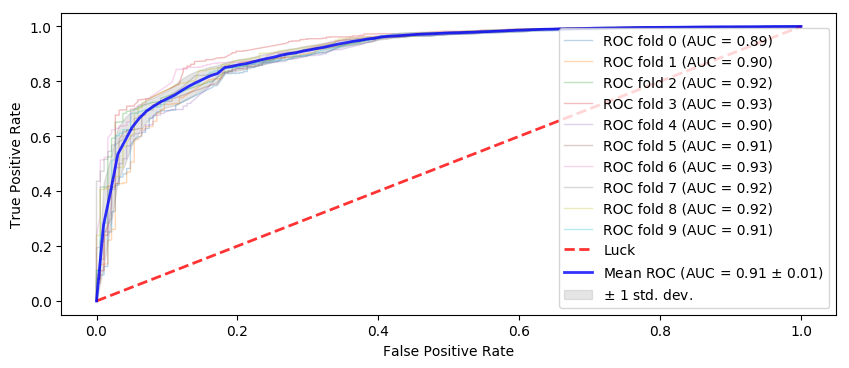

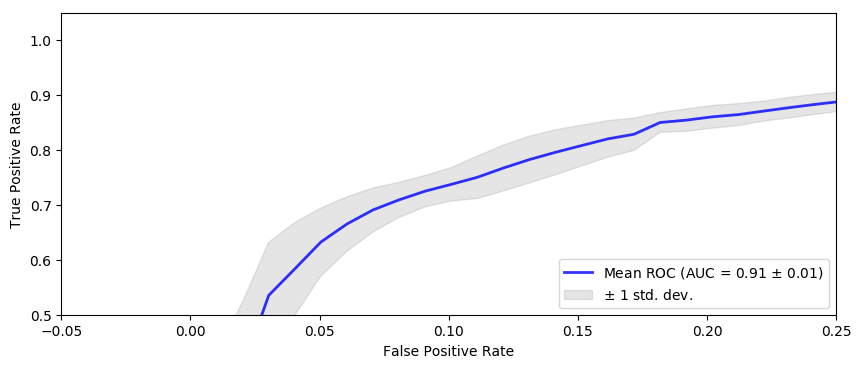

CPU times: user 3.19 s, sys: 6.23 s, total: 9.42 s
Wall time: 1.66 s


In [4]:
%%time
data = big_dataset[big_dataset.index.isin(strict_data.index)]
display(len(data))
data = shuffle(data)
(strict_fpr, strict_tpr, _) = train_plot_roc(np.array(data.drop('malware', axis=1)), data.malware)

# Loose Dataset

45865

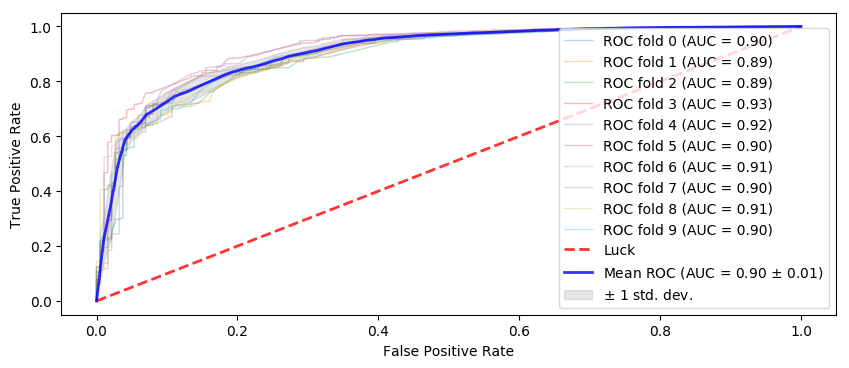

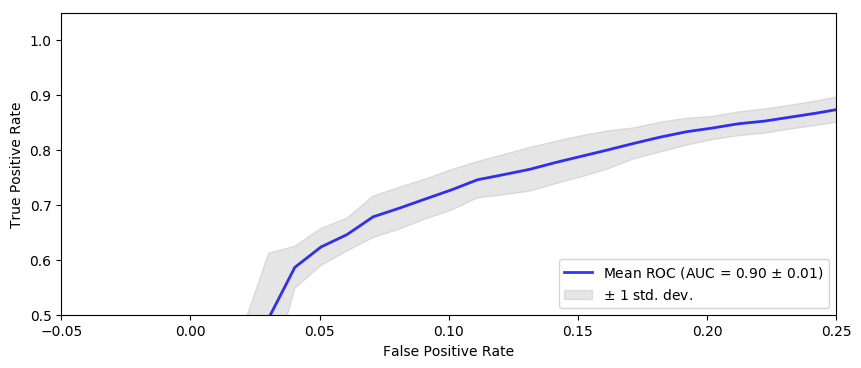

CPU times: user 4.06 s, sys: 5.87 s, total: 9.93 s
Wall time: 2.61 s


In [5]:
%%time
data = big_dataset[big_dataset.index.isin(loose_data.index)]
display(len(data))
data = shuffle(data)
(loose_fpr, loose_tpr, _) = train_plot_roc(np.array(data.drop('malware', axis=1)), data.malware)

# Real Dataset

151506

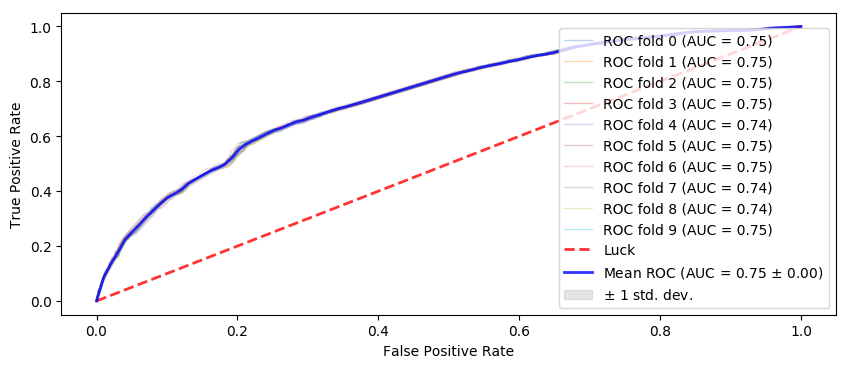

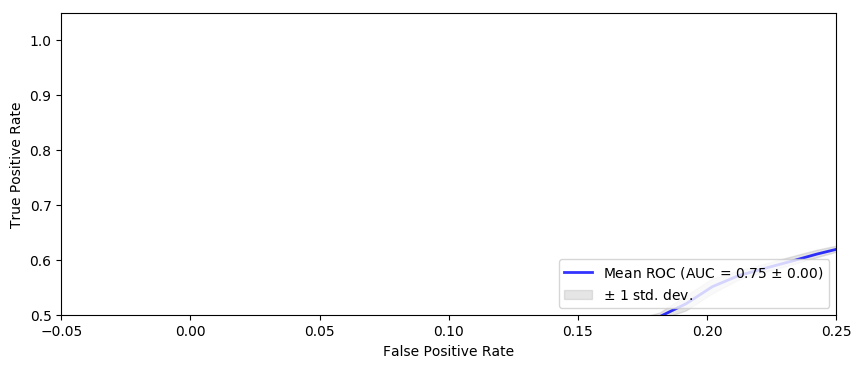

CPU times: user 9.46 s, sys: 5.98 s, total: 15.4 s
Wall time: 8.39 s


In [6]:
%%time
data = big_dataset
display(len(data))
data = shuffle(data)
(real_fpr, real_tpr, _) = train_plot_roc(np.array(data.drop('malware', axis=1)), data.malware)

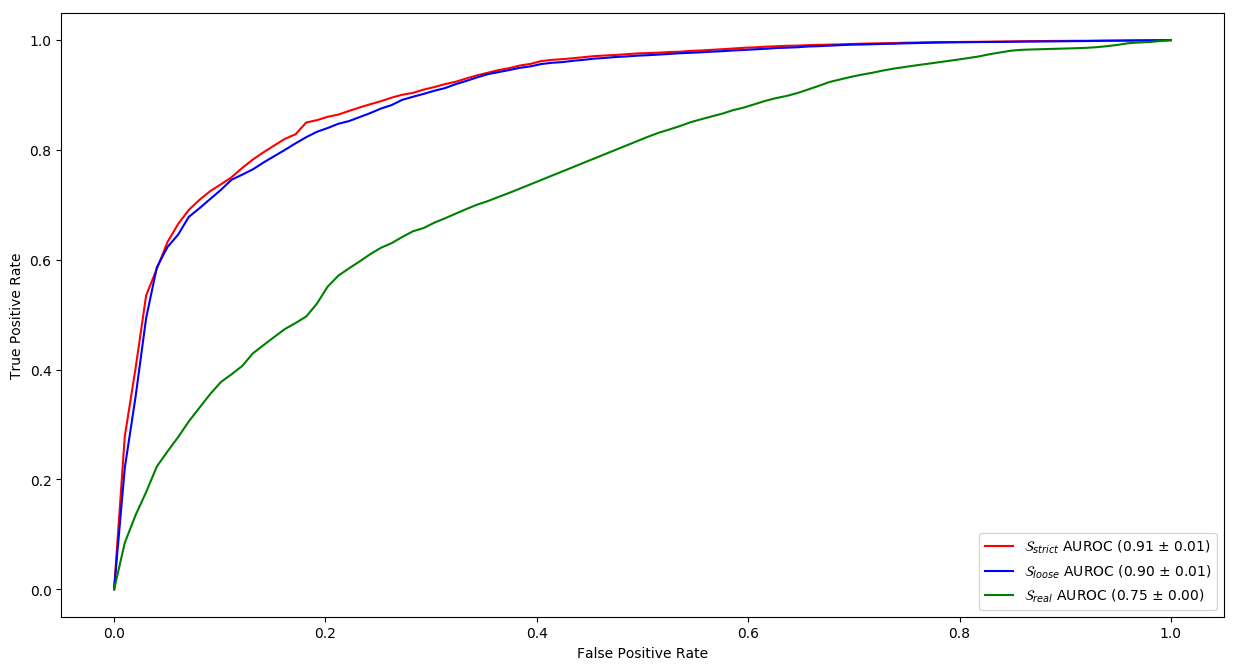

In [7]:
plt.figure(figsize=(15, 8), dpi=100)
plt.plot(strict_fpr, strict_tpr, color='r',
         label='$\mathcal{S}_{strict}$ AUROC (0.91 $\pm$ 0.01)')
plt.plot(loose_fpr, loose_tpr, color='b',
         label='$\mathcal{S}_{loose}$ AUROC (0.90 $\pm$ 0.01)')
plt.plot(real_fpr, real_tpr, color='g',
         label='$\mathcal{S}_{real}$ AUROC (0.75 $\pm$ 0.00)')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Strict Dataset Past-to-Present

In [8]:
auc_frame = []

In [9]:
data = big_dataset[big_dataset.index.isin(strict_data.index)]
display(len(data))

# Split dataset into fixed test and training
split_position = len(data) - int(len(data) * 0.1)
training_set = data[:split_position]
test_set = data[split_position:]

# Split into 10 training folds
train_size = int(len(training_set) / 10)

display('Training set: {}'.format(len(training_set)))
display('Test set: {}'.format(len(test_set)))

25835

'Training set: 23252'

'Test set: 2583'

In [10]:
%%time
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)
classifier = LogisticRegression(C=1)

x_test = test_set.drop('malware', axis=1)
y_test = test_set.malware
for i in range(10):
    fold_size = i*train_size + train_size
    x_training = training_set[:fold_size].drop('malware', axis=1)
    y_training = training_set[:fold_size].malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1

auc_frame.append(aucs)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)    

'Fold 0; Goodware/Malware ratio: 0.17, AUROC: 0.89'

'Fold 1; Goodware/Malware ratio: 0.09, AUROC: 0.89'

'Fold 2; Goodware/Malware ratio: 0.06, AUROC: 0.89'

'Fold 3; Goodware/Malware ratio: 0.05, AUROC: 0.89'

'Fold 4; Goodware/Malware ratio: 0.04, AUROC: 0.90'

'Fold 5; Goodware/Malware ratio: 0.05, AUROC: 0.90'

'Fold 6; Goodware/Malware ratio: 0.04, AUROC: 0.90'

'Fold 7; Goodware/Malware ratio: 0.04, AUROC: 0.91'

'Fold 8; Goodware/Malware ratio: 0.05, AUROC: 0.91'

'Fold 9; Goodware/Malware ratio: 0.05, AUROC: 0.91'

CPU times: user 1.35 s, sys: 3.05 s, total: 4.4 s
Wall time: 647 ms


# Loose Dataset Past-to-Present

In [11]:
data = big_dataset[big_dataset.index.isin(loose_data.index)]
display(len(data))

# Split dataset into fixed test and training
split_position = len(data) - int(len(data) * 0.1)
training_set = data[:split_position]
test_set = data[split_position:]

# Split into 10 training folds
train_size = int(len(training_set) / 10)

display('Training set: {}'.format(len(training_set)))
display('Test set: {}'.format(len(test_set)))

45865

'Training set: 41279'

'Test set: 4586'

In [12]:
%%time
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)
classifier = LogisticRegression(C=1)

x_test = test_set.drop('malware', axis=1)
y_test = test_set.malware
for i in range(10):
    fold_size = i*train_size + train_size
    x_training = training_set[:fold_size].drop('malware', axis=1)
    y_training = training_set[:fold_size].malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1

auc_frame.append(aucs)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)    

'Fold 0; Goodware/Malware ratio: 0.07, AUROC: 0.89'

'Fold 1; Goodware/Malware ratio: 0.05, AUROC: 0.89'

'Fold 2; Goodware/Malware ratio: 0.03, AUROC: 0.89'

'Fold 3; Goodware/Malware ratio: 0.03, AUROC: 0.90'

'Fold 4; Goodware/Malware ratio: 0.02, AUROC: 0.90'

'Fold 5; Goodware/Malware ratio: 0.02, AUROC: 0.90'

'Fold 6; Goodware/Malware ratio: 0.02, AUROC: 0.90'

'Fold 7; Goodware/Malware ratio: 0.02, AUROC: 0.90'

'Fold 8; Goodware/Malware ratio: 0.02, AUROC: 0.91'

'Fold 9; Goodware/Malware ratio: 0.03, AUROC: 0.91'

CPU times: user 2.07 s, sys: 3.67 s, total: 5.74 s
Wall time: 1.23 s


# Real Dataset Past-to-Present

In [13]:
data = big_dataset
display(len(data))

# Split dataset into fixed test and training
split_position = len(data) - int(len(data) * 0.1)
training_set = data[:split_position]
test_set = data[split_position:]

# Split into 10 training folds
train_size = int(len(training_set) / 10)

display('Training set: {}'.format(len(training_set)))
display('Test set: {}'.format(len(test_set)))

151506

'Training set: 136356'

'Test set: 15150'

In [14]:
%%time
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)
classifier = LogisticRegression(C=1)

x_test = test_set.drop('malware', axis=1)
y_test = test_set.malware
for i in range(10):
    fold_size = i*train_size + train_size
    x_training = training_set[:fold_size].drop('malware', axis=1)
    y_training = training_set[:fold_size].malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1

auc_frame.append(aucs)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)    

'Fold 0; Goodware/Malware ratio: 0.63, AUROC: 0.67'

'Fold 1; Goodware/Malware ratio: 0.54, AUROC: 0.67'

'Fold 2; Goodware/Malware ratio: 0.46, AUROC: 0.68'

'Fold 3; Goodware/Malware ratio: 0.38, AUROC: 0.66'

'Fold 4; Goodware/Malware ratio: 0.40, AUROC: 0.67'

'Fold 5; Goodware/Malware ratio: 0.41, AUROC: 0.67'

'Fold 6; Goodware/Malware ratio: 0.42, AUROC: 0.67'

'Fold 7; Goodware/Malware ratio: 0.45, AUROC: 0.68'

'Fold 8; Goodware/Malware ratio: 0.47, AUROC: 0.68'

'Fold 9; Goodware/Malware ratio: 0.53, AUROC: 0.68'

CPU times: user 5.27 s, sys: 4.94 s, total: 10.2 s
Wall time: 4.13 s


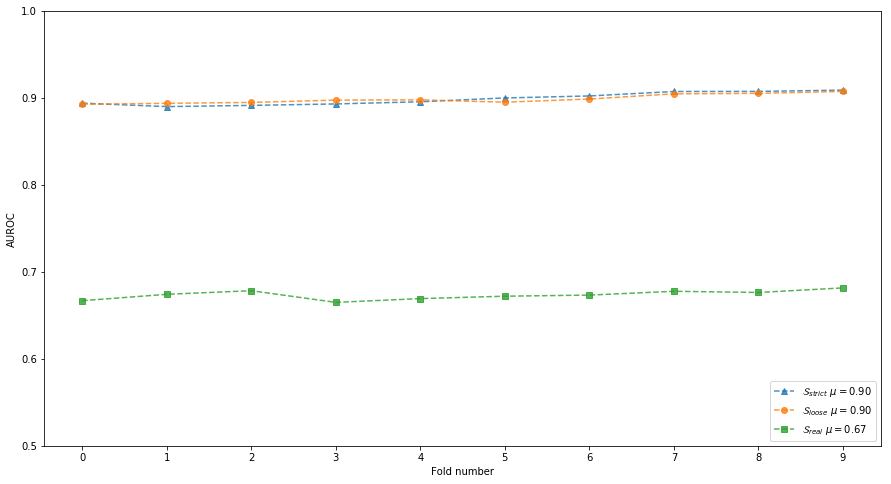

In [15]:
test = pd.DataFrame(auc_frame)
test.index = ['$\mathcal{S}_{strict}$ $\mu=0.90$', '$\mathcal{S}_{loose}$ $\mu=0.90$', '$\mathcal{S}_{real}$ $\mu=0.67$']
test = test.transpose()
ax = test.plot.line(figsize=(15, 8), style=['^', 'o', 's'], linestyle='--', alpha=0.8)
plt.ylim([0.5, 1.])
plt.xticks(range(10))
plt.ylabel('AUROC')
plt.xlabel('Fold number')
plt.legend(loc='lower right')
plt.show()

In [16]:
test.describe()

,$\mathcal{S}_{strict}$ $\mu=0.90$,$\mathcal{S}_{loose}$ $\mu=0.90$,$\mathcal{S}_{real}$ $\mu=0.67$
count,10.000000,10.000000,10.000000
mean,0.898989,0.898750,0.673424
std,0.007175,0.005234,0.005298
min,0.889995,0.892635,0.664917
25%,0.893280,0.894846,0.669926
50%,0.897746,0.897602,0.673728
75%,0.906079,0.903174,0.677314
max,0.908924,0.907430,0.681558


# Strict Dataset Present-to-Past

In [17]:
auc_frame = []

In [18]:
data = big_dataset[big_dataset.index.isin(strict_data.index)]
display(len(data))

# Split dataset into fixed test and training
split_position = len(data) - int(len(data) * 0.1)
training_set = data[:split_position][::-1]
test_set = data[split_position:]

# Split into 10 training folds
train_size = int(len(training_set) / 10)

display('Training set: {}'.format(len(training_set)))
display('Test set: {}'.format(len(test_set)))

25835

'Training set: 23252'

'Test set: 2583'

In [19]:
%%time
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)
classifier = LogisticRegression(C=1)

x_test = test_set.drop('malware', axis=1)
y_test = test_set.malware
for i in range(10):
    fold_size = i*train_size + train_size
    x_training = training_set[:fold_size].drop('malware', axis=1)
    y_training = training_set[:fold_size].malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1

auc_frame.append(aucs)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)    

'Fold 0; Goodware/Malware ratio: 0.07, AUROC: 0.90'

'Fold 1; Goodware/Malware ratio: 0.08, AUROC: 0.90'

'Fold 2; Goodware/Malware ratio: 0.06, AUROC: 0.90'

'Fold 3; Goodware/Malware ratio: 0.05, AUROC: 0.90'

'Fold 4; Goodware/Malware ratio: 0.06, AUROC: 0.90'

'Fold 5; Goodware/Malware ratio: 0.05, AUROC: 0.91'

'Fold 6; Goodware/Malware ratio: 0.04, AUROC: 0.91'

'Fold 7; Goodware/Malware ratio: 0.04, AUROC: 0.91'

'Fold 8; Goodware/Malware ratio: 0.04, AUROC: 0.91'

'Fold 9; Goodware/Malware ratio: 0.05, AUROC: 0.91'

CPU times: user 1.33 s, sys: 3.11 s, total: 4.44 s
Wall time: 666 ms


# Loose Dataset Present-to-Past

In [20]:
data = big_dataset[big_dataset.index.isin(loose_data.index)]
display(len(data))

# Split dataset into fixed test and training
split_position = len(data) - int(len(data) * 0.1)
training_set = data[:split_position][::-1]
test_set = data[split_position:]

# Split into 10 training folds
train_size = int(len(training_set) / 10)

display('Training set: {}'.format(len(training_set)))
display('Test set: {}'.format(len(test_set)))

45865

'Training set: 41279'

'Test set: 4586'

In [21]:
%%time
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)
classifier = LogisticRegression(C=1)

x_test = test_set.drop('malware', axis=1)
y_test = test_set.malware
for i in range(10):
    fold_size = i*train_size + train_size
    x_training = training_set[:fold_size].drop('malware', axis=1)
    y_training = training_set[:fold_size].malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1

auc_frame.append(aucs)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)    

'Fold 0; Goodware/Malware ratio: 0.06, AUROC: 0.90'

'Fold 1; Goodware/Malware ratio: 0.04, AUROC: 0.90'

'Fold 2; Goodware/Malware ratio: 0.03, AUROC: 0.90'

'Fold 3; Goodware/Malware ratio: 0.03, AUROC: 0.90'

'Fold 4; Goodware/Malware ratio: 0.03, AUROC: 0.90'

'Fold 5; Goodware/Malware ratio: 0.03, AUROC: 0.90'

'Fold 6; Goodware/Malware ratio: 0.02, AUROC: 0.90'

'Fold 7; Goodware/Malware ratio: 0.02, AUROC: 0.90'

'Fold 8; Goodware/Malware ratio: 0.02, AUROC: 0.91'

'Fold 9; Goodware/Malware ratio: 0.03, AUROC: 0.91'

CPU times: user 2.06 s, sys: 4.07 s, total: 6.13 s
Wall time: 1.07 s


# Real Dataset Present-to-Past

In [22]:
data = big_dataset
display(len(data))

# Split dataset into fixed test and training
split_position = len(data) - int(len(data) * 0.1)
training_set = data[:split_position][::-1]
test_set = data[split_position:]

# Split into 10 training folds
train_size = int(len(training_set) / 10)

display('Training set: {}'.format(len(training_set)))
display('Test set: {}'.format(len(test_set)))

151506

'Training set: 136356'

'Test set: 15150'

In [23]:
%%time
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)
classifier = LogisticRegression(C=1)

x_test = test_set.drop('malware', axis=1)
y_test = test_set.malware
for i in range(10):
    fold_size = i*train_size + train_size
    x_training = training_set[:fold_size].drop('malware', axis=1)
    y_training = training_set[:fold_size].malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1

auc_frame.append(aucs)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)    

'Fold 0; Goodware/Malware ratio: 1.28, AUROC: 0.70'

'Fold 1; Goodware/Malware ratio: 0.91, AUROC: 0.69'

'Fold 2; Goodware/Malware ratio: 0.85, AUROC: 0.70'

'Fold 3; Goodware/Malware ratio: 0.74, AUROC: 0.69'

'Fold 4; Goodware/Malware ratio: 0.68, AUROC: 0.69'

'Fold 5; Goodware/Malware ratio: 0.64, AUROC: 0.69'

'Fold 6; Goodware/Malware ratio: 0.55, AUROC: 0.68'

'Fold 7; Goodware/Malware ratio: 0.52, AUROC: 0.68'

'Fold 8; Goodware/Malware ratio: 0.52, AUROC: 0.68'

'Fold 9; Goodware/Malware ratio: 0.53, AUROC: 0.68'

CPU times: user 5.09 s, sys: 5.14 s, total: 10.2 s
Wall time: 4.03 s


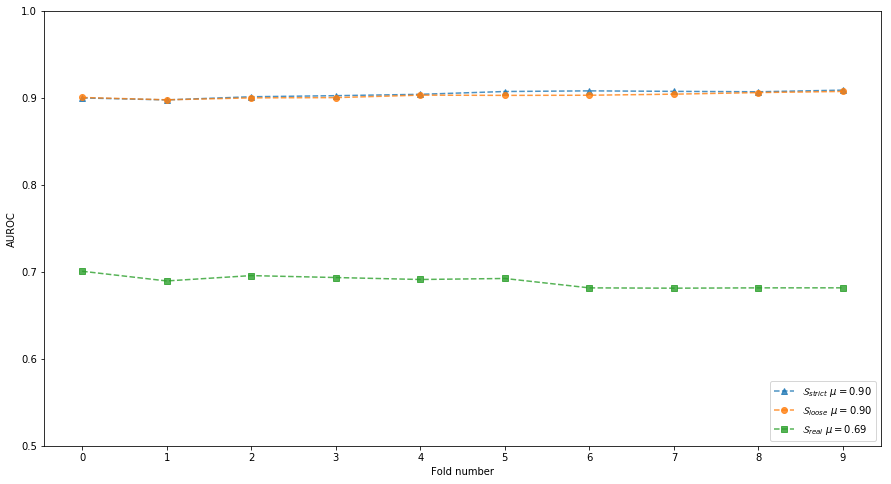

In [24]:
test = pd.DataFrame(auc_frame)
test.index = ['$\mathcal{S}_{strict}$ $\mu=0.90$', '$\mathcal{S}_{loose}$ $\mu=0.90$', '$\mathcal{S}_{real}$ $\mu=0.69$']
test = test.transpose()
ax = test.plot.line(figsize=(15, 8), style=['^', 'o', 's'], linestyle='--', alpha=0.8)
plt.ylim([0.5, 1.])
plt.xticks(range(10))
plt.ylabel('AUROC')
plt.xlabel('Fold number')
plt.legend(loc='lower right')
plt.show()

In [25]:
test.describe()

,$\mathcal{S}_{strict}$ $\mu=0.90$,$\mathcal{S}_{loose}$ $\mu=0.90$,$\mathcal{S}_{real}$ $\mu=0.69$
count,10.000000,10.000000,10.000000
mean,0.904454,0.902561,0.688898
std,0.003900,0.002952,0.007013
min,0.897701,0.897802,0.681222
25%,0.901623,0.900362,0.681598
50%,0.905576,0.902977,0.690377
75%,0.907468,0.904010,0.693195
max,0.908925,0.907431,0.700695


# Strict Dataset Sliding Window

In [26]:
final_rocs = []

In [27]:
data = big_dataset[big_dataset.index.isin(strict_data.index)]
display(len(data))

fold_size = test_size = int(len(data) / 10)
train_size = fold_size * 3


display('Training set: {}'.format(train_size))
display('Test set: {}'.format(test_size))

25835

'Training set: 7749'

'Test set: 2583'

In [28]:
%%time
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

start = 0
for i in range(7):
    training_set = data[start:start+train_size]
    test_set = data[start+train_size:start+train_size+test_size]
    
    start += fold_size
     
    x_training = training_set.drop('malware', axis=1)
    y_training = training_set.malware
    x_test = test_set.drop('malware', axis=1)
    y_test = test_set.malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
    
final_rocs += [(mean_fpr, mean_tpr)]

'Fold 0; Goodware/Malware ratio: 0.06, AUROC: 0.87'

'Fold 1; Goodware/Malware ratio: 0.01, AUROC: 0.87'

'Fold 2; Goodware/Malware ratio: 0.02, AUROC: 0.89'

'Fold 3; Goodware/Malware ratio: 0.03, AUROC: 0.88'

'Fold 4; Goodware/Malware ratio: 0.04, AUROC: 0.89'

'Fold 5; Goodware/Malware ratio: 0.04, AUROC: 0.95'

'Fold 6; Goodware/Malware ratio: 0.06, AUROC: 0.90'

CPU times: user 481 ms, sys: 1.23 s, total: 1.71 s
Wall time: 281 ms


# Loose Dataset Sliding Window

In [29]:
data = big_dataset[big_dataset.index.isin(loose_data.index)]
display(len(data))

fold_size = test_size = int(len(data) / 10)
train_size = fold_size * 3


display('Training set: {}'.format(train_size))
display('Test set: {}'.format(test_size))

45865

'Training set: 13758'

'Test set: 4586'

In [30]:
%%time
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

start = 0
for i in range(7):
    training_set = data[start:start+train_size]
    test_set = data[start+train_size:start+train_size+test_size]
    
    start += fold_size
     
    x_training = training_set.drop('malware', axis=1)
    y_training = training_set.malware
    x_test = test_set.drop('malware', axis=1)
    y_test = test_set.malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
    
final_rocs += [(mean_fpr, mean_tpr)]

'Fold 0; Goodware/Malware ratio: 0.03, AUROC: 0.84'

'Fold 1; Goodware/Malware ratio: 0.01, AUROC: 0.85'

'Fold 2; Goodware/Malware ratio: 0.00, AUROC: 0.87'

'Fold 3; Goodware/Malware ratio: 0.02, AUROC: 0.90'

'Fold 4; Goodware/Malware ratio: 0.02, AUROC: 0.87'

'Fold 5; Goodware/Malware ratio: 0.02, AUROC: 0.92'

'Fold 6; Goodware/Malware ratio: 0.03, AUROC: 0.90'

CPU times: user 1 s, sys: 2.13 s, total: 3.13 s
Wall time: 481 ms


# Real Dataset Sliding Window

In [31]:
data = big_dataset
display(len(data))

fold_size = test_size = int(len(data) / 10)
train_size = fold_size * 3


display('Training set: {}'.format(train_size))
display('Test set: {}'.format(test_size))

151506

'Training set: 45450'

'Test set: 15150'

In [32]:
%%time
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

start = 0
for i in range(7):
    training_set = data[start:start+train_size]
    test_set = data[start+train_size:start+train_size+test_size]
    
    start += fold_size
     
    x_training = training_set.drop('malware', axis=1)
    y_training = training_set.malware
    x_test = test_set.drop('malware', axis=1)
    y_test = test_set.malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    
    probas_ = classifier.fit(x_training, y_training).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    display('Fold {}; Goodware/Malware ratio: {:.2f}, AUROC: {:.2f}'.format(i, ngoodware/nmalware, roc_auc))
    i += 1
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
    
final_rocs += [(mean_fpr, mean_tpr)]

'Fold 0; Goodware/Malware ratio: 0.42, AUROC: 0.74'

'Fold 1; Goodware/Malware ratio: 0.33, AUROC: 0.72'

'Fold 2; Goodware/Malware ratio: 0.32, AUROC: 0.77'

'Fold 3; Goodware/Malware ratio: 0.39, AUROC: 0.72'

'Fold 4; Goodware/Malware ratio: 0.50, AUROC: 0.77'

'Fold 5; Goodware/Malware ratio: 0.57, AUROC: 0.70'

'Fold 6; Goodware/Malware ratio: 0.85, AUROC: 0.70'

CPU times: user 2.46 s, sys: 3.29 s, total: 5.75 s
Wall time: 1.58 s


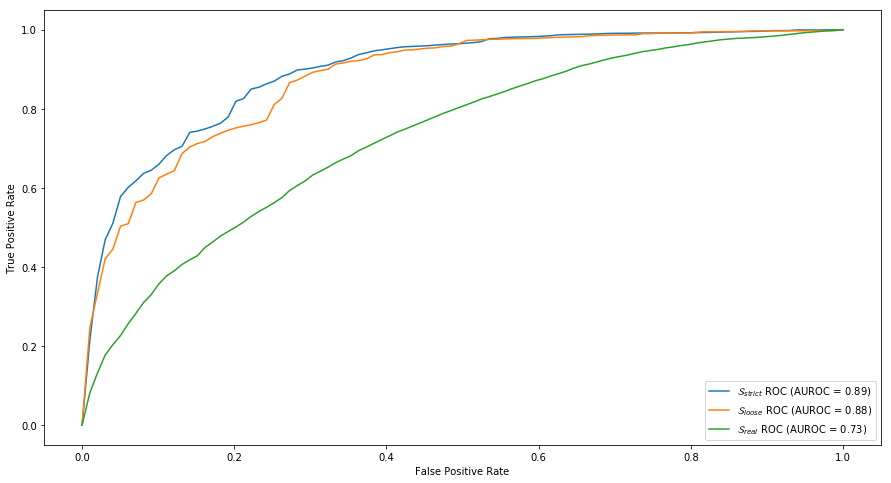

In [33]:
plt.figure(figsize=(15, 8))

fpr, tpr = final_rocs[0]
plt.plot(fpr, tpr, label='$\mathcal{S}_{strict}$ ROC (AUROC = %0.2f)' % (auc(fpr, tpr)))
fpr, tpr = final_rocs[1]
plt.plot(fpr, tpr, label='$\mathcal{S}_{loose}$ ROC (AUROC = %0.2f)' % (auc(fpr, tpr)))
fpr, tpr = final_rocs[2]
plt.plot(fpr, tpr, label='$\mathcal{S}_{real}$ ROC (AUROC = %0.2f)' % (auc(fpr, tpr)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()